<a href="https://colab.research.google.com/github/JLee823/2023-1st-AI-assisted-drug-discovery-SNU/blob/main/Week8_Intro_to_pytorch_geometric_and_Predicting_molecular_activities_using_graph_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to pyTorch geometric
----
이번 시간에는 pytorch_geometric의 다양한 Graph Neural Network layer를 이용해서 분자 물성 예측을 수행해본다.

이번 시간에는 더 많은 atom feature와 edge feature를 고려하여 GNN 학습을 수행해본다. 

In [ ]:
import torch
import numpy as np

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.cuda.manual_seed_all(1234)
np.random.seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
!nvidia-smi

## Installing pytorch geometric
----
pytorch geometric은 다양한 graph neural network 알고리즘을 미리 구현해놓은 library이다. 

https://pytorch-geometric.readthedocs.io/en/latest/index.html

이를 이용하면 처음부터 pytorch를 이용하여 구현하는 것이 비해서 상대적으로 손쉽게 graph neural network을 구현할 수 있다. 



In [ ]:
# Install required packages.
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv

A graph is used to model pairwise relations (edges) between objects (nodes). 

A single graph in PyG is described by an instance of **`torch_geometric.data.Data`**, which holds the following attributes by default:

**`data.x`**: Node feature matrix with shape `[num_nodes, num_node_features]`

**`data.edge_index`**: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

**`data.edge_attr`**: Edge feature matrix with shape `[num_edges, num_edge_features]`

**`data.y`**: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

**`data.pos`**: Node position matrix with shape `[num_nodes, num_dimensions]`

None of these attributes are required. In fact, the `Data` object is not even restricted to these attributes. 

We can, e.g., extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape `[3, num_faces]` and type torch.long.



We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:



In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data # basic graph class

# edge index:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

# node features:
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# generate a graph using the Data class
data = Data(x=x, edge_index=edge_index)
data

위의 코드는 아래의 그림과 같은 그래프를 나타낸다. 
* 0번, 1번 노드가 연결되어 있음. 
* 1번, 2번 노드가 연결되어 있음. 
* 0번 노드의 특징은 [-1]로 표현됨. 
* 1번 노드의 특징은 [0]으로 표현됨. 
* 2번 노드의 특징은 [1]로 표현됨. 

<img src="https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg" width=600>

Note that **`edge_index`**, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples. 

If you want to write your indices in the form of **`[num_edges, 2]`**, you should transpose and call contiguous on it before passing them to the data constructor:

In [ ]:
# edge index
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)

# node features
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

data

그래프 신경망을 이용하여 예측을 수행할 때, 크게 3가지 레벨에서 예측을 수행할 수 있다. 

1. 노드 수준: 목적값 y값의 개수가 각 노드의 개수와 동일함.  
2. 연결 수준: 목적값 y값의 개수가 연결의 개수와 동일함.
3. 그래프 수준: 하나의 그래프 전체에서 하나의 목적값을 예측함. 

<img src="https://velog.velcdn.com/images%2Fhixkix59%2Fpost%2F4249de11-3726-4e44-a025-8edd47019365%2Fimage.png" width=600>

Note that it is necessary that the elements in `edge_index` only hold indices in the range `{ 0, ..., num_nodes - 1}`. This is needed as we want our final data representation to be as compact as possible, e.g., we want to index the source and destination node features of the first edge `(0, 1)` via `x[0]` and `x[1]`, respectively. You can always check that your final Data objects fulfill these requirements by running [`validate()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data.validate). If the returned values is `True`, a given graph is valid:

In [ ]:
data.validate(raise_on_error=True)

Besides holding a number of node-level, edge-level or graph-level attributes, Data provides a number of useful utility functions, e.g.:



* data가 가지고 있는 속성

In [ ]:
print(data.keys)

* 노드 특성을 출력

In [ ]:
print(data['x'])

* Edge attribute가 존재는지 여부 확인. 

In [ ]:
'edge_attr' in data

In [ ]:
data.num_nodes

In [ ]:
data.num_edges

In [ ]:
data.num_node_features

* isolated node가 있는지?

In [ ]:
data.has_isolated_nodes()

* self-loop이 있는지? 

In [ ]:
data.has_self_loops()


* directed graph인지? 

In [ ]:
data.is_directed()


* Graph data instance를 GPU로 옮긴다. 

In [ ]:
# Transfer data object to GPU.
device = torch.device('cuda')
data = data.to(device)

## 내장되어 있는 그래프 데이터셋
-----

torch geometric에는 몇몇 데이터셋들이 이미 내장되어 있다. 

https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

이 중에서 [TUDataset](https://chrsmrrs.github.io/datasets/)에 포함되어 있는 enzyme dataset을 불러와서 한 번 살펴보도록 한다. 


In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset

# Check the size
print(f"Number of graphs in this dataset: {len(dataset)}")

# Check number of classes
print(f"Number of graph classes: {dataset.num_classes}")

# Check number of node featurs
print(f"Size of node features: {dataset.num_node_features}")

위 결과에서 알 수 있는 점은 ENZYME 데이터셋의 경우, 600개의 그래프로 이루어져있으며, 각 그래프는 6개의 class로 나뉘어져 있다. 각 노드는 3차원의 벡터로 표현된다. 

ENZYME 데이터셋에 있는 그래프 중에서 첫번째 그래프를 한 번 살펴보자. 

In [ ]:
data = dataset[0]
print(data)

data.is_undirected()

첫 번째 그래프는 37개의 노드, 168/2 = 84개의 연결을 가지고 있으며, 그래프 정보에 기반하여 그래프의 타입을 예측한다. 

In [ ]:
print(dataset[0].edge_index.t())

In [ ]:
print(dataset[0].x)

In [ ]:
print(dataset[0].y)

#RDKit을 이용한 분자를 그래프로 변환하기
------

In [ ]:
!pip install rdkit

In [ ]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric
from torch_geometric.data import Data

In [ ]:
torch.manual_seed(820823)

In [ ]:
import pandas as pd
import joblib

Pandas를 이용해서 데이터를 불러온다. 


참고 사이트: https://wikidocs.net/book/3488

In [ ]:
#pubchem = pd.read_csv("PubchemQC_HOMO-LUMO_100000.csv")
#pubchem = pd.read_csv("https://www.dropbox.com/s/stxhvcgk0kvs89m/PubchemQC_HOMO-LUMO_100000.csv?dl=1")
BACE = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/bace.csv")

In [ ]:
BACE

## 분자를 그래프로 나타내기

----
이번 예측에서는 H, B, C, N, O, F, P, S, Cl, Br, I 만으로 이루어진 분자들만 고려하도록 하겠습니다.

이를 위해서 간단히 분자가 H, B, C, N, O, F, P, S, Cl, Br, I만으로 구성되어 있는지를 확인하는 함수를 정의하겠습니다. 

In [ ]:
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I')
  flag = True
  for atm in mol.GetAtoms(): # 분자 안에 존재하는 모든 atom에 대해서 loop을 수행. 
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

In [ ]:
from tqdm import tqdm
import os

ligand_data = []
for smi, score in tqdm(zip(BACE["mol"], BACE["pIC50"])):
  mol = Chem.MolFromSmiles(smi)
  score = float(score)
  if check_atoms(mol): # 모든 atom들이 원하는 atom들로만 구성되어 있을 때.
    ligand_data.append((mol, score)) 
  else:
    print(f"{smi} has non-targeted atoms")
  continue
      
# Save mol-type variables.
joblib.dump(ligand_data, "BACE_data.joblib")


In [ ]:
print(f"Number of data: {len(ligand_data)}")

### Converting a molecule into a graph
----


#### one-hot encoding
------
분자의 특성을 feature vector로 변환할 때, categorical variable을 표현하는 방법 중에 가장 널리 사용되는 방법이 one-hot encoding이다. 

이는 n개의 선택지가 있을 때, 이를 n-차원의 bit vector로 표현한 후, 하나의 category에 대응되는 bit만 1로 표현하는 방법이다. 




<img src="https://blog.kakaocdn.net/dn/bQAqI1/btqYn4RUV8U/3gWF8KPkz2w0IsMzG6yduk/img.png" width=800>


<img src="https://mblogthumb-phinf.pstatic.net/MjAyMDAzMDFfMjgx/MDAxNTgzMDIyNzg0MTc2.yzaPKdZzM5RdLJor5Ps0KfU5w3TWHU2cnXFDkTczOKIg.z4NJn4MGiwF49FmX6Mg7qgouuNhhlL1CivvrG0Bza1og.PNG.handuelly/image.png?type=w800" width=800>

#### Hybridization type in RDKit
-------
분자를 그래프로 표현할 때, 여러가지 성질들을 one-hot encoding으로 나타낼 수 있다. 

예를 들어서 각 원자의 혼성 오비탈의 종류를 one-hot encoding으로 표현할 수 있다. 

https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.HybridizationType

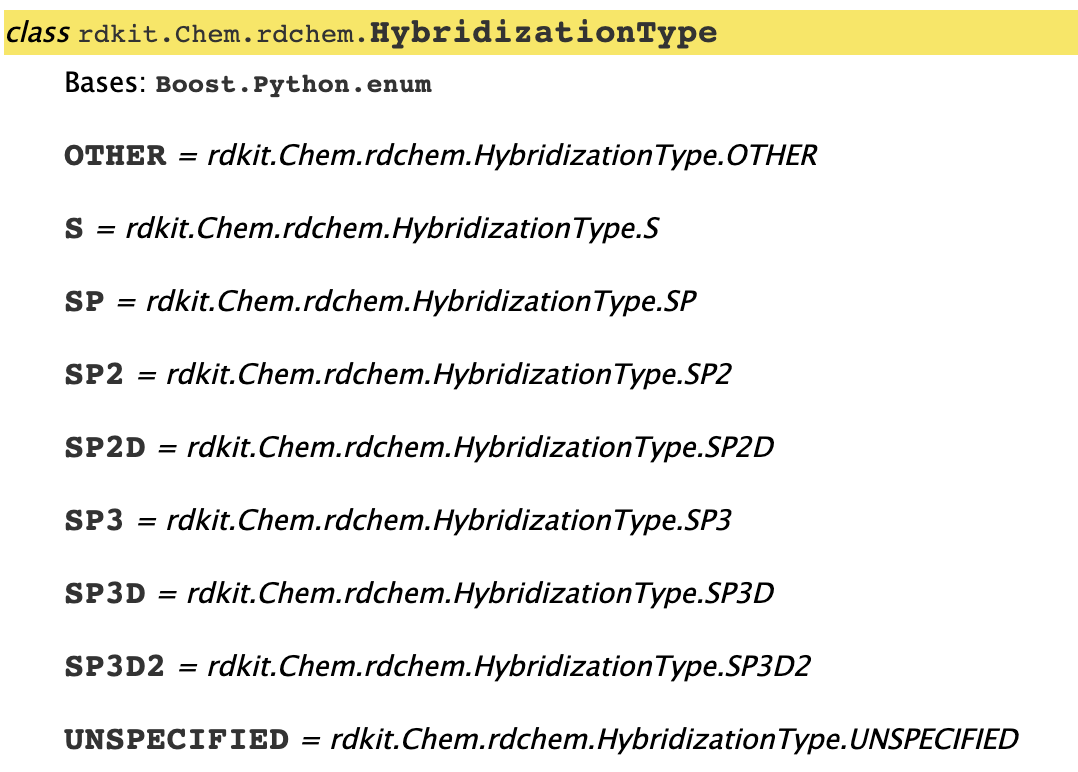

In [ ]:
def convert_mol_to_graph(mol, use_pos = False):
    
    #mol2 = Chem.AddHs(mol)
    mol2 = Chem.RemoveHs(mol)

    n_bonds = len(mol2.GetBonds()) # 분자의 공유 결합 개수 
    n_atoms = len(mol2.GetAtoms()) # 분자의 원자 개수
    
    node_attr = []
    #### node 속성 계산 시작 ####
    # RDKit으로 계산할 수 있는 Atom의 속성은 아래 링크에서 확인할 수 있다.
    # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
    # 
    #.        0.   1.   2.   3.   4.   5.   6.   7.   8.    9.  10.
    #        'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl' 'Br'  'I'
    valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8, 'Br':9, 'I':10}

    for atm_id in range(n_atoms):
        # Select an atom.
        atm = mol2.GetAtomWithIdx(atm_id)

        # Atom symbol check (9-dim)
        sym = atm.GetSymbol()
        atm_one_hot = [0] * len(valid_atoms) # 0이 9개 들어있는 리스트를 만든다. 
        idx = valid_atoms[sym] # sym에 해당하는 원소 기호가 몇 번째에 있는지?
        atm_one_hot[idx] = 1   # 해당되는 원소의 위치만 1로 바꾼다. 

        # Check hybridization (7-dim)
        hybrid = atm.GetHybridization()
        hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
        if hybrid == Chem.HybridizationType.SP3:
          hybrid_one_hot[0] = 1
        elif hybrid == Chem.HybridizationType.SP2:
          hybrid_one_hot[1] = 1
        elif hybrid == Chem.HybridizationType.SP:
          hybrid_one_hot[2] = 1
        elif hybrid == Chem.HybridizationType.S:
          hybrid_one_hot[3] = 1
        elif hybrid == Chem.HybridizationType.SP3D:
          hybrid_one_hot[4] = 1
        elif hybrid == Chem.HybridizationType.SP3D2:
          hybrid_one_hot[5] = 1
        else: # hybridization이 제대로 정의되지 않은 나머지의 모든 경우.
          hybrid_one_hot[6] = 1

        # aromatic 인지 아닌지?  (True/False)
        if atm.GetIsAromatic():
          arom = 1
        else:
          arom = 0

        # ring 안에 존재하는지 아닌지? (True/False)
        if atm.IsInRing():
          ring_flag = 1
        else:
          ring_flag = 0 
        
        # Degree (공유 결합의 개수)  (6-dim, one-hot)
        # 0, 1, 2, 3, 4, >=5    
        degree_one_hot = [0, 0, 0, 0, 0, 0]
        degree = atm.GetTotalDegree()
        if degree >= 5: # 5개 이상의 공유 결합을 가지는 원자.
          degree_one_hot[5]=1
        else:
          degree_one_hot[degree]=1

        # Number of hydrogens (5-dim, one-hot)
        # 결합되어 있는 수소의 개수. 
        # 0, 1, 2, 3, >=4
        num_h = atm.GetTotalNumHs()
        hydrogen_one_hot = [0, 0, 0, 0, 0]
        if num_h >= 4:
          hydrogen_one_hot[4] = 1
        else:
          hydrogen_one_hot[num_h] = 1

        # Chirality (4-dim, one-hot)
        chiral = atm.GetChiralTag()
        if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
          chiral_one_hot = [1, 0, 0, 0]
        # Counter-clock-wise (반시계)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
          chiral_one_hot = [0, 1, 0, 0]
        # Clockwise (시계방향)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
          chiral_one_hot = [0, 0, 1, 0]
        # Chirality 정의되지 않음.
        elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
          chiral_one_hot = [0, 0, 0, 1]

        # 원자 특성 계산 [원자 symbol one-hot, 공유 결합 개수, 전체 valence의 개수 (explicit + implicit), is an atom aromatic (True/False)? ]
        # 더 추가 가능!
        # in total 25-dim.
        # 11-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
        attr = atm_one_hot + \
                hybrid_one_hot + \
                degree_one_hot + \
                hydrogen_one_hot + \
                chiral_one_hot + \
                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

        #print(atm_id, attr)
        node_attr.append(attr)
    
    #### node 속성 계산 완료 ####

    edge_index = []
    edge_attr = []
    edge_weight = []
    for edge_idx in range(n_bonds): # 전체 공유 결합에 대해서 loop을 돌린다. 

        bond = mol2.GetBondWithIdx(edge_idx) # 각 공유 결합에 대해서 시작 atom과 끝 atom의 인덱스를 확인. 
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # undirected graph를 만들기 위해서 순서를 바꿔서 edge를 2번 넣어준다. 
        
        # BondType (4-dimensional one-hot)
        btype = bond.GetBondType() # 공유 결합의 종류.
        if btype == Chem.rdchem.BondType.SINGLE:
            bond_one_hot = [1, 0, 0, 0]
            edge_weight.extend([1.0, 1.0])
        elif btype == Chem.rdchem.BondType.AROMATIC:
            bond_one_hot = [0, 1, 0, 0]
            edge_weight.extend([1.5, 1.5])
        elif btype == Chem.rdchem.BondType.DOUBLE:
            bond_one_hot = [0, 0, 1, 0]
            edge_weight.extend([2.0, 2.0])
        elif btype == Chem.rdchem.BondType.TRIPLE:
            bond_one_hot = [0, 0, 0, 1]   
            edge_weight.extend([3.0, 3.0])  
        
        # BondStereo (6-dimensional one-hot)
        stype = bond.GetStereo()
        if stype == Chem.rdchem.BondStereo.STEREOANY:
          stereo_one_hot = [1, 0, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOCIS:
          stereo_one_hot = [0, 1, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOE:
          stereo_one_hot = [0, 0, 1, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREONONE:
          stereo_one_hot = [0, 0, 0, 1, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
          stereo_one_hot = [0, 0, 0, 0, 1, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOZ:
          stereo_one_hot = [0, 0, 0, 0, 0, 1]
        
        # Is this bond included in a ring?
        if bond.IsInRing():
          ring_bond = 1
        else:
          ring_bond = 0

        # Is this bond a conjugated bond?
        if bond.GetIsConjugated():
          conjugate = 1
        else:
          conjugate = 0
        
        # In total 12-dimensional edge attribute 
        # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
        # Can you image more?
        attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 차원의 공유 결합 속성. 

        # 분자는 undirected graph이므로 edge가 두 번 정의된다. 
        # 그러므로 동일한 attribute를 두 번 넣어주어야 한다.
        edge_attr.append(attr)
        edge_attr.append(attr)
    #### edge 속성 계산 완료 ####


    # PyTorch Tensor로 변환. 
    edge_attr = torch.tensor(edge_attr, dtype = torch.float)
    node_attr = torch.tensor(node_attr, dtype = torch.float)
    edge_index = torch.tensor(edge_index, dtype = torch.long)
    edge_index = edge_index.t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype = torch.float)
    
    
    # 만일 3D 좌표 정보를 사용한다면
    if use_pos: 
        val = AllChem.EmbedMolecule(mol2)
        if val !=0:
          print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
          return None   
         
        pos_list = [] # this is optional
        for atm_id in range(n_atoms):
          # Get Atomic Position. 
          atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
          crd = [atm_pos.x, atm_pos.y, atm_pos.z]
          pos_list.append(crd)
        
        pos = torch.tensor(pos_list, dtype=torch.float)
    else:
      pos = None
    #print(edge_attr.shape)
    #print(node_attr.shape)
    #print(edge_index.shape)

    return edge_index, node_attr, edge_attr, pos, edge_weight

In [ ]:
ligand_data[0][0]

In [ ]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(ligand_data[0][0])

In [ ]:
d0 = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, pos = pos, edge_weight = edge_weight)

In [ ]:
print(d0)

In [ ]:
d0.num_nodes

* 그래프를 networkx 모듈을 이용해서 간단히 그려보자. 


In [ ]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx

G = to_networkx(d0)
nx.draw_networkx(G)

## 이제 분자들을 하나씩 PyG의 Data type으로 변환해봅시다.
----

In [ ]:
fname='BACE_converted_graph.joblib'
data_list = []

for mol, score in tqdm(ligand_data):
  result = convert_mol_to_graph(mol)
  if result is None:
    continue

  edge_index, node_attr, edge_attr, pos, edge_weight = result
  y = torch.tensor([[score]], dtype = torch.float)
  dtmp = Data(x = node_attr, 
              edge_index = edge_index, 
              edge_attr = edge_attr, 
              edge_weight = edge_weight, 
              pos = pos, y = y
              )
  data_list.append(dtmp)
joblib.dump(data_list, fname)
print(f"{fname} is saved!")

### torch_geometric DataLoader
------
일반적인 pytorch와 마찬가지로 torch_geometric에도 데이터셋을 배치에 맞추어 읽어들이는 DataLoader가 구현되어 있다. 

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
import random
random.seed(12345)
random.shuffle(data_list)
n_data = len(data_list)

In [ ]:
train_set, val_set, test_set = data_list[:int(n_data*0.7)], data_list[int(n_data*0.7):int(n_data*0.8)], data_list[int(n_data*0.8):]

print(f"Number of training set: {len(train_set)}")
print(f"Number of Validaation set: {len(val_set)}")
print(f"Number of test set: {len(test_set)}")

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last = False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, drop_last = False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, drop_last = False)

In [ ]:
print(train_loader)

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

In [ ]:
for batch in train_loader:
    print(batch)
    print(batch.batch)
    print(batch.num_graphs)
    print(batch.num_node_features)
    break

In [ ]:
data = data_list[0]
print(data.keys)

In [ ]:
data.num_node_features

In [ ]:
n_epoch = 200

## Count_parameters 함수 정의
----

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# 실제로 Graph Convolutional Network (GCN)을 정의해봅시다. 

----

Convolution 3층과 마지막 1차원의 출력을 내어놓는 네트워크 입니다. 


## Model definition
----

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn.functional import gelu
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.nn import global_mean_pool

class myGCN(torch.nn.Module):
    def __init__(self, in_channel=35, hidden_layer_size=70):
        super().__init__()
        self.conv1 = GCNConv(in_channel, hidden_layer_size) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.bn1 = BatchNorm(hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn2 = BatchNorm(hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn3 = BatchNorm(hidden_layer_size)


        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        #self.lin1_bn = BatchNorm(int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.gelu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.gelu(x)

        # READOUT 
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x) # 70 dim -> 35-dim
        #x = self.lin1_bn(x)
        x = F.elu(x)

        x = self.lin2(x) # 35 dim -> 1-dim

        return x

In [ ]:
model = myGCN(in_channel = 37, hidden_layer_size = 70)
model.to(device)

In [ ]:
print(model)

In [ ]:
count_parameters(model)

## Test function
----

In [ ]:
def test(loader):
    model.eval()
    error = 0.0
    out_all = []
    true = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        tmp = (out - data.y)**2
        error += tmp.sum().item()  # Check against ground-truth labels.
        
        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in data.y])
        
    return error / len(loader.dataset), out_all, true  # Derive ratio of correct predictions.

## Train function
----

In [ ]:
def train():
  for idx, batch in enumerate(train_loader):
    out = model(batch.to(device))
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.
    if idx%100 == 0:
      lr = scheduler.get_last_lr()
      print(f"IDX: {idx:5d}\tLoss: {loss:.4f}\tLR:{lr}")

In [ ]:
n_epoch = 200

## Define optimizer
----

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

## Perform training!
----

* learning rate을 동적(dynamic)하게 조절하는 learning rate scheduler를 이용해서 학습을 시켜보자. 
* 다양한 learning rate scheduler는 다음에서 찾아볼 수 있다: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

train_acc_list = []
val_acc_list = []

best_val_rmse = 9999.9

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
model.train()

for epoch in range(1, n_epoch):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    scheduler.step()

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    # Save the best model
    if val_acc < best_val_rmse:
      best_epoch = epoch
      best_val_rmse = val_acc
      best_train_rmse = train_acc
      torch.save(model, "Best_GCN_model_v1.pt")

    print("-"*80)
    print(f'Epoch: {epoch:03d}, Train RMSE: {train_acc:.4f}, Val RMSE: {val_acc:.4f}')
    print("-"*80)
    print(f"Best Epoch: {best_epoch:03d}")
    print(f"Best val   RMSE: {best_val_rmse:.4f}")
    print(f"Best train RMSE: {best_train_rmse:.4f}")
    print('='*80)

## Loss 값의 변화를 plot 해보자.
----


### draw_loss_change function
---

In [ ]:
import matplotlib.pyplot as plt

def draw_loss_change(train_loss, val_loss):
  plt.figure(figsize=(8,8)) # 빈 그림을 정의
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  #plt.plot(test_loss, color = 'g',  label = 'Test loss') # test set loss
  plt.ylim(ymin=0.0, ymax=5.0)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best') # label을 표시 하겠다. 

In [ ]:
draw_loss_change(train_acc_list, val_acc_list)

In [ ]:
test_acc, out_all, true_all = test(test_loader)
print(f"Test set RMSE: {test_acc:.4f} (pIC50)")

#### pIC50와 binding affinity 값 사이의 관계
-----


단백질과 리간드가 결합하는 반응은 다음과 같이 쓸 수 있다.
P + L --> PL

이 때의 결합 자유 에너지는 다음과 같이 쓸 수 있다. 

\begin{align}
\Delta G & =-RT \ln \frac{[PL]}{[P][L]} \\
\end{align}



pIC50는 [PL]==[P] 인 경우의 [L] 값에 $-log_{10}$을 취한, $-log_{10}[L]$이므로 다음과 같이 쓸 수 있다. 

\begin{equation}
\Delta G = RT \frac{\log_{10}\frac{1}{[L]}}{log_{10}e}  = -RT/\log_{10}e * p\mathrm{IC50}
\end{equation}

R = 1.987 cal/mol K, T = 300 K 을 가정하면, 

\begin{equation}
\Delta G = -1.373 \mathrm{kcal/mol} * pIC50 
\end{equation}

가 된다. 

In [ ]:
import matplotlib.pyplot as plt
#out_all = [x.detach().numpy() for x in out_all]
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(experimental, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
print(true_all)

In [ ]:
corr = np.corrcoef(experimental, prediction)
print(corr)

In [ ]:
print(f"Pearson R: {corr[0,1]:.4f}")

In [ ]:
torch.save(model, "GCN_epoch_200.pt")

# GCN layer에 edge weight 정보를 넣으면 더 좋아질까? 
-----

* Single bond 는 가중치 1
* Doulbe bond 는 가중치 2
* Triple bond 는 가중치 3
* Aromatic은 가중치 1.5

이런식으로 edge_weight를 정의하였음. 


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class mymodel2(torch.nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        
        hidden_layer_size = n_feat*2 # This should be optimized!

        self.conv1 = GCNConv(n_feat, hidden_layer_size) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.bn1 = BatchNorm(hidden_layer_size)

        self.conv2 = GCNConv(n_feat*2, hidden_layer_size)
        self.bn2 = BatchNorm(hidden_layer_size)

        self.conv3 = GCNConv(n_feat*2, hidden_layer_size)
        self.bn3 = BatchNorm(hidden_layer_size)

        #self.conv4 = GCNConv(n_feat*2, n_feat*2)
        #self.conv5 = GCNConv(n_feat*2, n_feat*2)
        self.lin1 = Linear(hidden_layer_size, n_feat)
        self.lin2 = Linear(n_feat, 1)
        
    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index, edge_weight) # 이번에는 edge_weight를 고려해서 학습한다, edge_weight는 optional한 정보. 
        x = self.bn1(x)
        x = F.gelu(x)
        #x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        #x = F.dropout(F.gelu(x), training=self.training)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        
        #x = F.dropout(F.gelu(x), training=self.training)
        #x = self.conv4(x, edge_index, edge_weight)
        #x = F.elu(x)
        #x = self.conv5(x, edge_index, edge_weight)
        #x = F.elu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.elu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = mymodel2(n_feat=37)
model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
n_epoch = 200

In [ ]:
train_acc_list = []
val_acc_list = []

best_val_rmse = 9999.9

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
model.train()

for epoch in range(1, n_epoch):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    scheduler.step()

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)
    
    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    if val_acc < best_val_rmse:
      best_epoch = epoch
      best_val_rmse = val_acc
      best_train_rmse = train_acc
      torch.save(model, "best_GCN_model_v2.pt")

    print("-"*80)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    print("-"*80)
    print(f"Best Epoch: {best_epoch:03d}")
    print(f"Best val   RMSE: {best_val_rmse:.4f}")
    print(f"Best train RMSE: {best_train_rmse:.4f}")
    print('='*80)


In [ ]:
test_acc, out_all, true_all = test(test_loader)
print(f"Test RMSE: {test_acc:.4f} (pIC50)")

## 결론: edge_weight를 고려하는 것이 큰 도움이 되지 않는다.
----
생각해볼 문제: edge_weight (가중치) 가 분자의 공유 결합을 표현할 때 적절한가? 



In [ ]:
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
corr = np.corrcoef(experimental, prediction)
r = corr[0,1]
print(f"Pearson R: {r:.4f}")

In [ ]:
draw_loss_change(train_acc_list, val_acc_list)

In [ ]:
torch.save(model, f"GCN_with_edge_weight_epoch{n_epoch}")

# Graph Attentive Network
----
GCNConv 말고 다른 graph convolution layer인 [Graph Attentive Network](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html)의 성능을 알아봅시다. 

ref: https://arxiv.org/abs/1710.10903


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

class my_GAT_model(torch.nn.Module):
    def __init__(self, n_feat, n_hidden):
        super().__init__()
        self.conv1 = GATConv(n_feat, n_hidden) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATConv(n_hidden, n_hidden)
        self.conv3 = GATConv(n_hidden, n_hidden)

        self.lin1 = Linear(n_hidden, int(n_hidden/2))
        self.lin2 = Linear(int(n_hidden/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr) # node_attribute와 edge_index만 사용하고 있음. -> edge의 attribute는 사용하고 있지 않음. 
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GAT_model(37, 74)
model.to(device)

In [ ]:
count_parameters(model)

### optimizer initialization
----

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

### Perform training
-------

In [ ]:
train_acc_list = []
val_acc_list = []

best_val_rmse = 9999.9
# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
model.train()

for epoch in range(1, n_epoch):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    scheduler.step()
    
    # Train loss
    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    # Validation loss
    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    if val_acc < best_val_rmse:
      best_epoch = epoch
      best_val_rmse = val_acc
      best_train_rmse = train_acc
      torch.save(model, "best_GAT_model.pt")

    print("-"*80)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    print("-"*80)
    print(f"Best Epoch: {best_epoch:03d}")
    print(f"Best val   RMSE: {best_val_rmse:.4f}")
    print(f"Best train RMSE: {best_train_rmse:.4f}")
    print('='*80)

### Analysis
----

* Test set RMSE calculation
-------

In [ ]:
test_acc, out_all, true_all = test(test_loader)
print(f"Test RMSE: {test_acc:.4f} (pIC50)")

* Draw scatter plot


In [ ]:
import matplotlib.pyplot as plt

experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("Experiment", fontsize='xx-large')
plt.ylabel("Prediction", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
np.corrcoef(experimental, prediction)

In [ ]:
draw_loss_change(train_acc_list, val_acc_list)

# 어떤 layer가 어떤 정보를 사용하는가? 
----
## GNN Cheatsheet

https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html#

## GATv2 model test
----

이번에는 **edge attribute(공유 결합의 속성)**를 사용하는 새로운 모델인 [GATv2](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv) 모델을 이용해서 edge attribute를 고려하는 모델을 학습해보자. 


ref: https://arxiv.org/abs/2105.14491

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class myGATv2Conv_model(torch.nn.Module):
    def __init__(self, n_feat, edge_dim):
        super().__init__()
        n_hidden = n_feat*2
        self.conv1 = GATv2Conv(n_feat, n_hidden, edge_dim=edge_dim) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATv2Conv(n_hidden, n_hidden, edge_dim=edge_dim)
        self.conv3 = GATv2Conv(n_hidden, n_hidden, edge_dim=edge_dim)
        #self.conv4 = GATv2Conv(70, 70, edge_dim=12)
        #self.conv5 = GATv2Conv(70, 70, edge_dim=12)

        self.lin1 = Linear(n_hidden, n_hidden)
        self.lin2 = Linear(n_hidden, 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr) # Edge attribute
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = myGATv2Conv_model(n_feat = 37, edge_dim = 12)
model.to(device)

In [ ]:
count_parameters(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

### Train a GATv2 model
----


In [ ]:
train_acc_list = []
val_acc_list = []

best_val_rmse = 9999.9

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
model.train()

for epoch in range(1, n_epoch):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    scheduler.step()

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    if val_acc < best_val_rmse:
      best_epoch = epoch
      best_val_rmse = val_acc
      best_train_rmse = train_acc
      torch.save(model, "GATv2_epoch_200_best.pt")

    print("-"*80)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    print("-"*80)
    print(f"Best Epoch: {best_epoch:03d}")
    print(f"Best val   RMSE: {best_val_rmse:.4f}")
    print(f"Best train RMSE: {best_train_rmse:.4f}")
    print('='*80)

### Analysis
----

#### Test set loss
------

In [ ]:
test_acc, out_all, true_all = test(test_loader)
print(f"Test RMSE: {test_acc:.4f}")

#### Draw loss
----


In [ ]:
draw_loss_change(train_acc_list, val_acc_list)

In [ ]:
import matplotlib.pyplot as plt

experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

#### Correlation coefficient
----


In [ ]:
cc = np.corrcoef(experimental, prediction)[0,1]
print(f"Pearson correlation coefficient: {cc:.4f}")

# AttentiveFP 모델을 사용해보자.
----

torch_geometric에서는 이미 논문에서 제시된 여러가지 모델들을 구현해 놓았다. 

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#models

연습을 위해서 그 중에서 AttentiveFP 모델의 문서를 참고하여 이미 구현된 AttentiveFP 모델을 이용해서 여러분만의 예측 모델을 구축해보세요. 

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.AttentiveFP

[Source code of AttentiveFP](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/attentive_fp.html#AttentiveFP)

ref: Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism

https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959

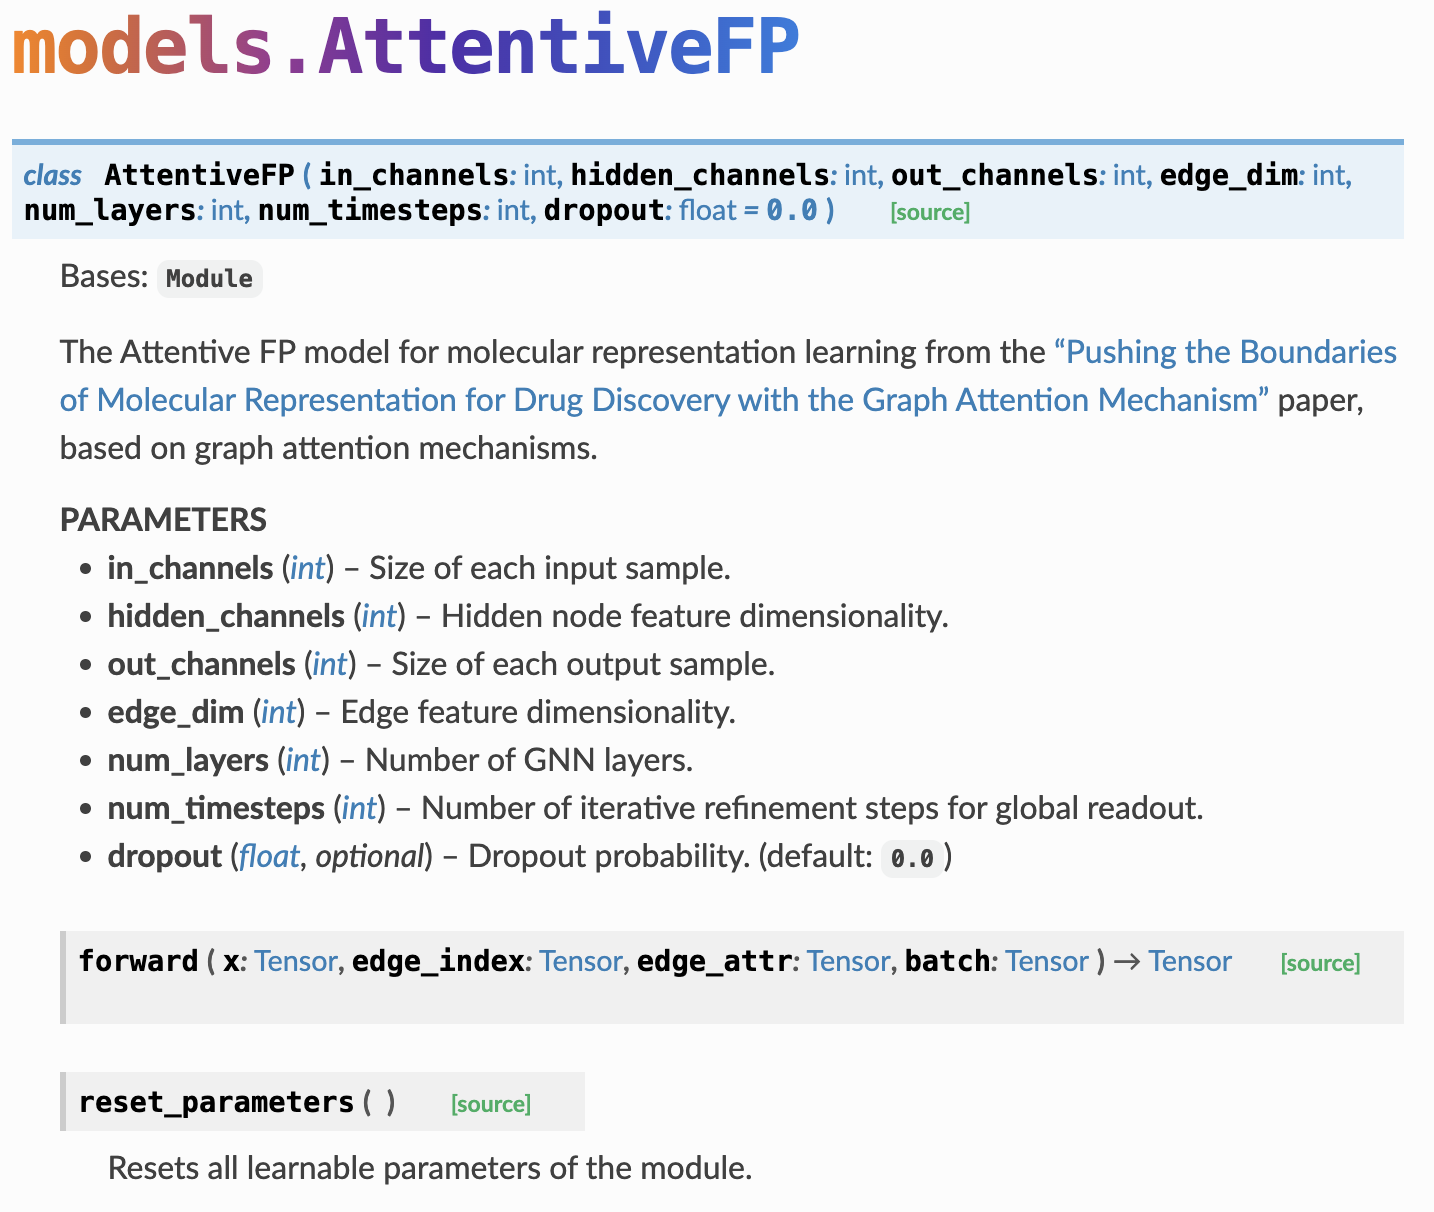

* Class input argument에 맞춰서 모델을 정의함. 

In [ ]:
from torch_geometric.nn import AttentiveFP

n_feat = 37
n_hidden = 74

model=AttentiveFP(n_feat, n_hidden, 1, 12, 3, 3, 0.1)
model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
def train():
  model.train()
  for idx, batch in enumerate(train_loader):
    # make predictions
    out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
    # calculate loss
    loss = criterion(out.to(device), batch.y.to(device))
    # calculate gradient
    loss.backward() 
    # Update parameters based on gradients.
    optimizer.step()       
    # Clear gradients.
    optimizer.zero_grad()  
    if idx%10 == 0:
      print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [ ]:
def test(loader):
  model.eval()
  error = 0.0
  out_all = []
  true = []
  for batch in loader:  # Iterate in batches over the training/test dataset.
    out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
    tmp = (out.to(device) - batch.y.to(device))**2
    error += tmp.sum().item()   # Check against ground-truth labels.
        
    out_all.extend([x.item() for x in out])
    true.extend([x.item() for x in batch.y])
        
  return error / len(loader.dataset), out_all, true  # Derive ratio of correct predictions.


In [ ]:
train_acc_list = []
val_acc_list = []

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
model.train()

for epoch in range(1, 200):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    scheduler.step()

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train RMSE: {train_acc:.4f}, Val RMSE: {val_acc:.4f}')

In [ ]:
test_rmse, predictions, true_all = test(test_loader)
print(f"Test RMSE: {test_rmse:.4f}")

In [ ]:
draw_loss_change(train_acc_list, val_acc_list)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(true_all, predictions, marker = '.')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

# (Exercise #1) Build you own network using other layer, GraphConv layer

또 다른 모델인 GraphConv layer를 이용해서 모델을 만들어 보라~

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv, GraphConv
from torch_geometric.nn import global_mean_pool

class my_GraphConv_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(...) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GraphConv(...)
        self.conv3 = GraphConv(...)
        self.conv4 = GraphConv(...)
        self.conv5 = GraphConv(...)

        self.lin1 = Linear(...)
        self.lin2 = Linear(...)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)
        
        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GraphConv_model()
print(model)
count_parameters(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
for epoch in range(1, 200):
    print("="*100)
    print("Epoch: ", epoch)
    train()
    train_acc, out_tmp, true_tmp = test(train_loader)
    val_acc, val_pred, val_true = test(val_loader)
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

In [ ]:
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)